In [6]:
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm


class PINN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(PINN, self).__init__()
        # Define neural network layers
        self.layers = nn.ModuleList(
            [
                (
                    nn.Linear(input_size if i == 0 else hidden_size, hidden_size)
                    if i % 2 == 0
                    else nn.Tanh()
                )
                for i in range(20)
            ]
        )
        # Output layer for concentration (C)
        self.layers.append(nn.Linear(hidden_size, output_size))

        # Learnable parameters: D and R (initially set as trainable parameters)
        self.D = nn.Parameter(
            torch.tensor([10.0], dtype=torch.float32, requires_grad=True)
        )  # Diffusion coefficient
        self.R = nn.Parameter(
            torch.tensor([10.0], dtype=torch.float32, requires_grad=True)
        )  # Sorption coefficient

        # Loss function and optimizer
        self.loss = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)

    def forward(self, x):
        """Feedforward pass to get concentration profile."""
        for layer in self.layers:
            x = layer(x)
        return x

    def residual_loss(self, xtrain):
        """Compute physics-based residual loss for the diffusion-sorption equation."""
        g = xtrain.clone()
        g.requires_grad = True
        u_pred = self.forward(g)  # Predicted concentration

        # Compute first derivatives
        u_grad = torch.autograd.grad(
            u_pred, g, torch.ones_like(u_pred), retain_graph=True, create_graph=True
        )[0]
        u_x = u_grad[:, [0]]  # ∂C/∂x
        u_t = u_grad[:, [1]]  # ∂C/∂t

        # Compute second derivative (diffusion term)
        u_xx = torch.autograd.grad(u_x, g, torch.ones_like(u_x), create_graph=True)[0][
            :, [0]
        ]  # ∂²C/∂x²

        # Compute the residual
        residual = u_t - (self.D / self.R) * u_xx  # Corrected residual equation

        return self.loss(
            residual, torch.zeros_like(residual).to(xtrain.device)
        )  # Residual should be zero

    def total_loss(self, xtrain, utrain):
        """Compute total loss = data loss + physics residual loss."""
        data_loss = self.loss(
            self.forward(xtrain), utrain
        )  # Compare predicted to true concentration
        residual_loss = self.residual_loss(xtrain)  # Physics-based loss
        return data_loss, residual_loss, data_loss + residual_loss

    def train_model(self, xtrain, utrain, epochs=1000):
        """Train the PINN model."""
        for epoch in tqdm(range(epochs)):
            self.optimizer.zero_grad()
            data_loss, res_loss, total_loss = self.total_loss(xtrain, utrain)
            total_loss.backward()
            self.optimizer.step()

            if epoch % 200 == 0:
                print(
                    f"Epoch {epoch}, Loss {total_loss.item()}, "
                    f"Data Loss {data_loss.item()}, Residual Loss {res_loss.item()}, "
                    f"D {self.D.item()}, Kd {self.R.item()}"
                )

In [7]:
import h5py

Nx = 100
Nt = 201

with h5py.File(
    "/home/shusrith/projects/torch/NoisyICML/pde-gen/diff-sorp/diff_sorp.h5", "r"
) as f:
    dtrue = f["10"]["D"][()]
    rtrue = f["10"]["R"][()]
    C_all = f["10"]["data"][:]
    f.close()
# Create input (x, t) and output (C) tensors
x = np.linspace(0, 10, Nx)
t = np.linspace(0, 1, Nt)
X, T = np.meshgrid(x, t)
X_train = torch.tensor(
    np.hstack((X.flatten()[:, None], T.flatten()[:, None])), dtype=torch.float32
).to("cuda")
C_train = torch.tensor(C_all.flatten()[:, None], dtype=torch.float32).to("cuda")
X_train.shape, C_train.shape

(torch.Size([20100, 2]), torch.Size([20100, 1]))

In [8]:
dtrue, rtrue

(66.99740786856688, 72.14302761066313)

In [9]:
idx = np.random.choice(Nx * Nt, 10000, replace=False)
xtrain = X_train[idx]
ctrain = C_train[idx]
xtrain.shape, ctrain.shape

(torch.Size([10000, 2]), torch.Size([10000, 1]))

In [10]:
model = PINN(2, 20, 1).to("cuda")
model.train_model(xtrain, ctrain, epochs=10000)

  0%|          | 19/10000 [00:00<00:55, 181.34it/s]

Epoch 0, Loss 0.28681856393814087, Data Loss 0.2868185341358185, Residual Loss 2.4014340738176543e-08, D 9.9998779296875, Kd 10.0001220703125


  2%|▏         | 232/10000 [00:01<00:52, 187.61it/s]

Epoch 200, Loss 0.009664722718298435, Data Loss 0.006597144063562155, Residual Loss 0.003067578887566924, D 9.752574920654297, Kd 10.246601104736328


  4%|▍         | 435/10000 [00:02<00:48, 197.80it/s]

Epoch 400, Loss 0.001937549328431487, Data Loss 0.0010308142518624663, Residual Loss 0.0009067350183613598, D 9.601278305053711, Kd 10.39428997039795


  6%|▌         | 622/10000 [00:03<00:46, 199.91it/s]

Epoch 600, Loss 0.0012902449816465378, Data Loss 0.0010033774888142943, Residual Loss 0.0002868675219360739, D 9.53700065612793, Kd 10.456038475036621


  8%|▊         | 825/10000 [00:04<00:46, 199.29it/s]

Epoch 800, Loss 0.000839702901430428, Data Loss 0.0006485980120487511, Residual Loss 0.00019110490393359214, D 9.499556541442871, Kd 10.491690635681152


 10%|█         | 1023/10000 [00:05<00:48, 184.91it/s]

Epoch 1000, Loss 0.0007737947744317353, Data Loss 0.0006171851418912411, Residual Loss 0.0001566096325404942, D 9.475194931030273, Kd 10.514753341674805


 12%|█▏        | 1227/10000 [00:06<00:45, 192.08it/s]

Epoch 1200, Loss 0.0007340922602452338, Data Loss 0.0006012932863086462, Residual Loss 0.00013279897393658757, D 9.456892967224121, Kd 10.532025337219238


 14%|█▍        | 1435/10000 [00:07<00:42, 203.88it/s]

Epoch 1400, Loss 0.0006998261669650674, Data Loss 0.00058592768618837, Residual Loss 0.00011389850988052785, D 9.44227409362793, Kd 10.54577922821045


 16%|█▌        | 1623/10000 [00:08<00:44, 187.98it/s]

Epoch 1600, Loss 0.0006900153821334243, Data Loss 0.0005840631783939898, Residual Loss 0.00010595217463560402, D 9.431458473205566, Kd 10.555933952331543


 18%|█▊        | 1837/10000 [00:09<00:43, 188.06it/s]

Epoch 1800, Loss 0.0006295733037404716, Data Loss 0.000554230937268585, Residual Loss 7.534238829975948e-05, D 9.42474365234375, Kd 10.562233924865723


 20%|██        | 2024/10000 [00:10<00:40, 198.41it/s]

Epoch 2000, Loss 0.000603353139013052, Data Loss 0.000535662635229528, Residual Loss 6.769050378352404e-05, D 9.421258926391602, Kd 10.56550121307373


 22%|██▏       | 2220/10000 [00:11<00:41, 187.08it/s]

Epoch 2200, Loss 0.0005896441289223731, Data Loss 0.0005221153260208666, Residual Loss 6.752880290150642e-05, D 9.420654296875, Kd 10.566069602966309


 24%|██▍       | 2424/10000 [00:12<00:43, 175.72it/s]

Epoch 2400, Loss 0.000568814342841506, Data Loss 0.000511151272803545, Residual Loss 5.766307731391862e-05, D 9.422463417053223, Kd 10.564360618591309


 26%|██▋       | 2626/10000 [00:13<00:39, 188.47it/s]

Epoch 2600, Loss 0.00055555475410074, Data Loss 0.0004987649153918028, Residual Loss 5.678983870893717e-05, D 9.424311637878418, Kd 10.562623977661133


 28%|██▊       | 2818/10000 [00:14<00:39, 179.98it/s]

Epoch 2800, Loss 0.0005458372179418802, Data Loss 0.0004816271539311856, Residual Loss 6.421008583856747e-05, D 9.429726600646973, Kd 10.557517051696777


 30%|███       | 3035/10000 [00:15<00:39, 175.87it/s]

Epoch 3000, Loss 0.0005286482628434896, Data Loss 0.0004794491978827864, Residual Loss 4.919905404676683e-05, D 9.433829307556152, Kd 10.553633689880371


 32%|███▏      | 3231/10000 [00:16<00:37, 179.24it/s]

Epoch 3200, Loss 0.0005166588234715164, Data Loss 0.0004673663934227079, Residual Loss 4.9292455514660105e-05, D 9.438142776489258, Kd 10.549544334411621


 34%|███▍      | 3421/10000 [00:18<00:36, 182.43it/s]

Epoch 3400, Loss 0.0005166089977137744, Data Loss 0.0004629544273484498, Residual Loss 5.365454489947297e-05, D 9.443525314331055, Kd 10.544435501098633


 36%|███▋      | 3632/10000 [00:19<00:34, 181.96it/s]

Epoch 3600, Loss 0.0004924879176542163, Data Loss 0.0004454438167158514, Residual Loss 4.704411549028009e-05, D 9.448995590209961, Kd 10.539214134216309


 38%|███▊      | 3835/10000 [00:20<00:32, 187.52it/s]

Epoch 3800, Loss 0.0004818490706384182, Data Loss 0.00043205631664022803, Residual Loss 4.979274672223255e-05, D 9.449751853942871, Kd 10.538496971130371


 40%|████      | 4036/10000 [00:21<00:34, 172.79it/s]

Epoch 4000, Loss 0.0004902406362816691, Data Loss 0.00042756227776408195, Residual Loss 6.267833668971434e-05, D 9.452414512634277, Kd 10.535947799682617


 42%|████▏     | 4232/10000 [00:22<00:33, 171.15it/s]

Epoch 4200, Loss 0.0004541593079920858, Data Loss 0.0004025813832413405, Residual Loss 5.157793566468172e-05, D 9.452492713928223, Kd 10.535880088806152


 44%|████▍     | 4429/10000 [00:23<00:32, 171.10it/s]

Epoch 4400, Loss 0.0004329120274633169, Data Loss 0.0003792012867052108, Residual Loss 5.37107334821485e-05, D 9.448311805725098, Kd 10.539910316467285


 46%|████▋     | 4639/10000 [00:24<00:28, 186.99it/s]

Epoch 4600, Loss 0.000395571521949023, Data Loss 0.0003418802807573229, Residual Loss 5.369125574361533e-05, D 9.441324234008789, Kd 10.54664134979248


 48%|████▊     | 4820/10000 [00:25<00:29, 176.72it/s]

Epoch 4800, Loss 0.0003471054951660335, Data Loss 0.00029665097827091813, Residual Loss 5.045452053309418e-05, D 9.434874534606934, Kd 10.552854537963867


 50%|█████     | 5023/10000 [00:27<00:36, 136.29it/s]

Epoch 5000, Loss 0.0004581604152917862, Data Loss 0.00037219427758827806, Residual Loss 8.596612315159291e-05, D 9.436060905456543, Kd 10.551714897155762


 52%|█████▏    | 5233/10000 [00:28<00:29, 162.80it/s]

Epoch 5200, Loss 0.0002488167956471443, Data Loss 0.00020988311734981835, Residual Loss 3.893367829732597e-05, D 9.439252853393555, Kd 10.548635482788086


 54%|█████▍    | 5427/10000 [00:29<00:33, 136.30it/s]

Epoch 5400, Loss 0.00022704516595695168, Data Loss 0.00018878333503380418, Residual Loss 3.826183456112631e-05, D 9.443190574645996, Kd 10.544842720031738


 56%|█████▌    | 5619/10000 [00:31<00:26, 164.67it/s]

Epoch 5600, Loss 0.0006202575750648975, Data Loss 0.0004813143750652671, Residual Loss 0.00013894318544771522, D 9.447887420654297, Kd 10.540312767028809


 58%|█████▊    | 5825/10000 [00:32<00:28, 147.91it/s]

Epoch 5800, Loss 0.00019654133939184248, Data Loss 0.0001587765000294894, Residual Loss 3.77648466383107e-05, D 9.447962760925293, Kd 10.540258407592773


 60%|██████    | 6020/10000 [00:33<00:22, 177.68it/s]

Epoch 6000, Loss 0.00018791297043208033, Data Loss 0.0001490904251113534, Residual Loss 3.8822541682748124e-05, D 9.450946807861328, Kd 10.537364959716797


 62%|██████▏   | 6233/10000 [00:34<00:23, 158.36it/s]

Epoch 6200, Loss 0.00017146801110357046, Data Loss 0.00013482362555805594, Residual Loss 3.6644385545514524e-05, D 9.453295707702637, Kd 10.535079956054688


 64%|██████▍   | 6427/10000 [00:36<00:20, 173.14it/s]

Epoch 6400, Loss 0.0001672175421845168, Data Loss 0.00012877685367129743, Residual Loss 3.844069578917697e-05, D 9.454713821411133, Kd 10.53368854522705


 66%|██████▋   | 6632/10000 [00:37<00:21, 156.57it/s]

Epoch 6600, Loss 0.00014567645848728716, Data Loss 0.0001117838328354992, Residual Loss 3.3892625651787966e-05, D 9.456124305725098, Kd 10.532296180725098


 68%|██████▊   | 6831/10000 [00:38<00:19, 161.71it/s]

Epoch 6800, Loss 0.0001519899960840121, Data Loss 0.00011267013178439811, Residual Loss 3.931986429961398e-05, D 9.459049224853516, Kd 10.529398918151855


 70%|███████   | 7033/10000 [00:39<00:16, 183.68it/s]

Epoch 7000, Loss 0.000267052004346624, Data Loss 0.00017661463061813265, Residual Loss 9.043737372849137e-05, D 9.461480140686035, Kd 10.526982307434082


 72%|███████▏  | 7228/10000 [00:40<00:16, 171.91it/s]

Epoch 7200, Loss 0.00011701764742610976, Data Loss 8.740525663597509e-05, Residual Loss 2.961239079013467e-05, D 9.464105606079102, Kd 10.524369239807129


 74%|███████▍  | 7426/10000 [00:42<00:15, 163.33it/s]

Epoch 7400, Loss 0.0001533112081233412, Data Loss 0.00010145771375391632, Residual Loss 5.185349436942488e-05, D 9.467453956604004, Kd 10.521034240722656


 76%|███████▋  | 7636/10000 [00:43<00:14, 165.12it/s]

Epoch 7600, Loss 0.00010594286140985787, Data Loss 7.712566730333492e-05, Residual Loss 2.8817194106522948e-05, D 9.47079849243164, Kd 10.517695426940918


 78%|███████▊  | 7831/10000 [00:44<00:12, 170.91it/s]

Epoch 7800, Loss 0.00010097988706547767, Data Loss 7.285993342520669e-05, Residual Loss 2.8119957278249785e-05, D 9.473941802978516, Kd 10.514552116394043


 80%|████████  | 8034/10000 [00:45<00:11, 171.02it/s]

Epoch 8000, Loss 0.0003411065845284611, Data Loss 0.0001848302490543574, Residual Loss 0.0001562763354741037, D 9.478090286254883, Kd 10.510403633117676


 82%|████████▏ | 8234/10000 [00:46<00:10, 166.98it/s]

Epoch 8200, Loss 0.000147829603520222, Data Loss 9.085689816856757e-05, Residual Loss 5.697270535165444e-05, D 9.481002807617188, Kd 10.50748348236084


 84%|████████▍ | 8441/10000 [00:48<00:08, 189.94it/s]

Epoch 8400, Loss 9.415230306331068e-05, Data Loss 6.34706811979413e-05, Residual Loss 3.068162186536938e-05, D 9.484258651733398, Kd 10.504228591918945


 86%|████████▋ | 8633/10000 [00:49<00:07, 186.13it/s]

Epoch 8600, Loss 0.00017684089834801853, Data Loss 0.00010200771794188768, Residual Loss 7.483318768208846e-05, D 9.487513542175293, Kd 10.500968933105469


 88%|████████▊ | 8825/10000 [00:50<00:06, 179.98it/s]

Epoch 8800, Loss 0.0002451468026265502, Data Loss 0.00012968832743354142, Residual Loss 0.0001154584824689664, D 9.490649223327637, Kd 10.497831344604492


 90%|█████████ | 9030/10000 [00:51<00:05, 186.55it/s]

Epoch 9000, Loss 7.687848119530827e-05, Data Loss 5.2452043746598065e-05, Residual Loss 2.4426433810731396e-05, D 9.492815017700195, Kd 10.495662689208984


 92%|█████████▏| 9228/10000 [00:52<00:04, 177.64it/s]

Epoch 9200, Loss 0.00014264078345149755, Data Loss 6.492750253528357e-05, Residual Loss 7.771327364025638e-05, D 9.495820999145508, Kd 10.492647171020508


 94%|█████████▍| 9426/10000 [00:53<00:03, 189.36it/s]

Epoch 9400, Loss 0.00010212593770120293, Data Loss 6.116729491623119e-05, Residual Loss 4.0958642784971744e-05, D 9.497834205627441, Kd 10.490628242492676


 96%|█████████▌| 9616/10000 [00:54<00:02, 165.46it/s]

Epoch 9600, Loss 6.890253280289471e-05, Data Loss 4.675776290241629e-05, Residual Loss 2.2144766262499616e-05, D 9.500204086303711, Kd 10.488253593444824


 98%|█████████▊| 9821/10000 [00:56<00:01, 151.41it/s]

Epoch 9800, Loss 0.00019286897440906614, Data Loss 9.74233407760039e-05, Residual Loss 9.544563363306224e-05, D 9.50251293182373, Kd 10.485940933227539


100%|██████████| 10000/10000 [00:57<00:00, 175.22it/s]


In [25]:
model.D.item()

6.576700210571289

tensor(-0.0021)


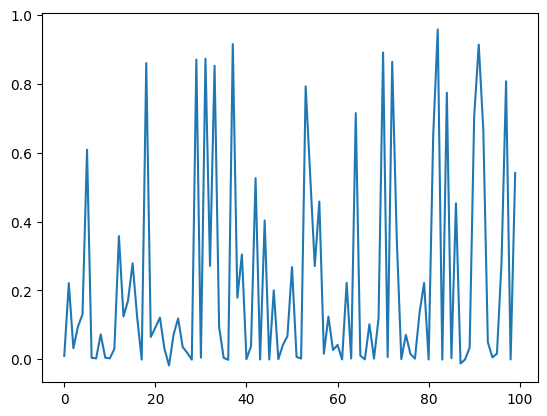

In [28]:
import matplotlib.pyplot as plt

with torch.no_grad():
    C_pred = model.forward(xtrain).cpu().numpy()
    C_pred = C_pred.reshape((Nx, 100))
    print(torch.mean(ctrain.cpu() - C_pred.flatten()))
    plt.plot(C_pred[0], label="Predicted")
    plt.show()